# NN (L) Global Sustainable Equity time series forecasting using Prophet

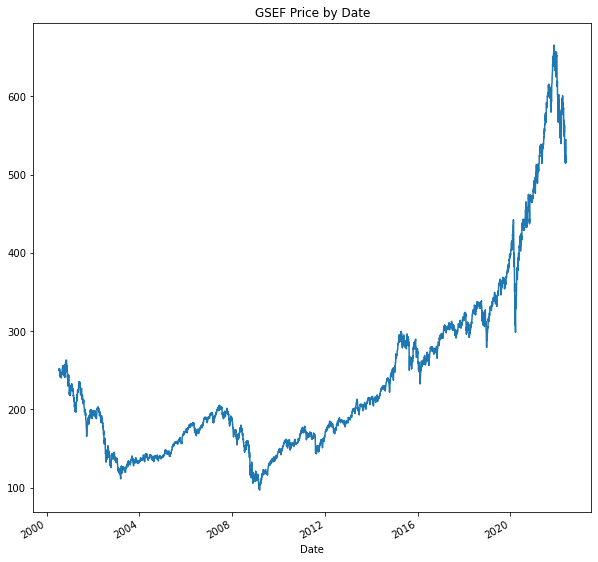

In [1]:
import timeit
start_time = timeit.default_timer()

# Import libraries
import time
import datetime as dt
import pandas as pd
import io
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_column',None)
tomorrow = (dt.date.today() + dt.timedelta(days=1)).isoformat() #get tomorrow in iso format as needed'''
url = pd.read_html("https://markets.ft.com/data/funds/tearsheet/historical?s=LU0119216553:EUR", header=0)
table = url[0]
gsef_latest = table[['Date', 'Close']]
gsef_latest_selected= gsef_latest.copy()

gsef_latest_selected['Date'] = gsef_latest_selected.loc[:,'Date'].str[-12:]
gsef_latest_selected['Date'] = pd.to_datetime(gsef_latest_selected['Date'], dayfirst=True)

gsef_historical= pd.read_csv('gsef_output/historical_gsef.csv', parse_dates=['Date'], dayfirst=True)

gsef = pd.concat([gsef_latest_selected, gsef_historical], ignore_index=True).sort_values(by="Date")

gsef = gsef.reset_index(drop=True)

gsef['pct_change']= (gsef["Close"].pct_change()*100).round(2)

gsef = gsef.drop_duplicates('Date')

gsef.to_csv('gsef_output/historical_gsef.csv', index=False)

gsef.plot(x= 'Date', y='Close', figsize=(10,10), title= 'GSEF Price by Date', legend=False)

historical_chart= 'gsef_output/gsef_historical.png'

import os
if os.path.exists(historical_chart):
  os.remove(historical_chart)
else:
  print("The historical chart didn't exist and it has been created.")

plt.savefig('gsef_output/gsef_historical.png')

plt.show()

In [2]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet

In [4]:
# Brief Description of our dataset
gsef.describe()

Close   pct_change
count  5529.000000  5528.000000
mean    238.421933     0.020074
std     116.881959     1.081935
min      96.810000    -9.930000
25%     157.420000    -0.470000
50%     195.400000     0.070000
75%     291.280000     0.550000
max     665.450000     9.540000

In [5]:
gsef.info() # Check whether the date is as object type or date type

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5529 entries, 0 to 5547
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        5529 non-null   datetime64[ns]
 1   Close       5529 non-null   float64       
 2   pct_change  5528 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 172.8 KB


In [6]:
gsef.head()

Date   Close  pct_change
0 2000-07-07  250.00         NaN
1 2000-07-10  250.00        0.00
2 2000-07-11  250.00        0.00
3 2000-07-12  249.61       -0.16
4 2000-07-13  249.80        0.08

Steps for using Prophet:
- Make sure you replace closing price for y and date for ds.
- Fit that dataframe to Prophet in order to detect future patterns.
- Predict the upper and lower prices of the closing price.

In [7]:
m = Prophet(daily_seasonality=False)

# Drop the columns
gsef = gsef.drop('pct_change', axis=1)
gsef.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

gsef.head()

ds       y
0 2000-07-07  250.00
1 2000-07-10  250.00
2 2000-07-11  250.00
3 2000-07-12  249.61
4 2000-07-13  249.80

In [8]:
m.fit(gsef)

In [9]:
# Create Future dates
future_prices = m.make_future_dataframe(periods=365)

# Predict Prices
forecast = m.predict(future_prices)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
5889 2023-05-23  670.059887  638.126360  702.693003
5890 2023-05-24  670.688035  638.458024  705.543446
5891 2023-05-25  671.045119  639.469667  703.480420
5892 2023-05-26  671.478783  641.806520  705.642221
5893 2023-05-27  667.422211  635.018473  702.426338

You can plot the forecast by calling the Prophet.plot method and passing in your forecast dataframe.

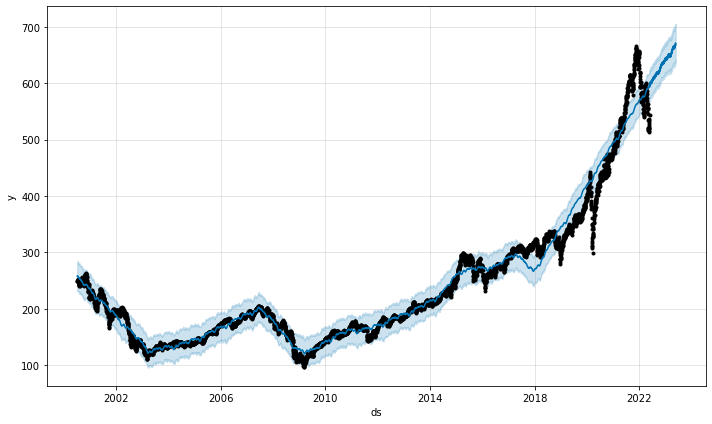

In [10]:
fig1 = m.plot(forecast)

If you want to see the forecast components, you can use the Prophet.plot_components method. By default you’ll see the trend, yearly seasonality, and weekly seasonality of the time series. If you include holidays, you’ll see those here, too.

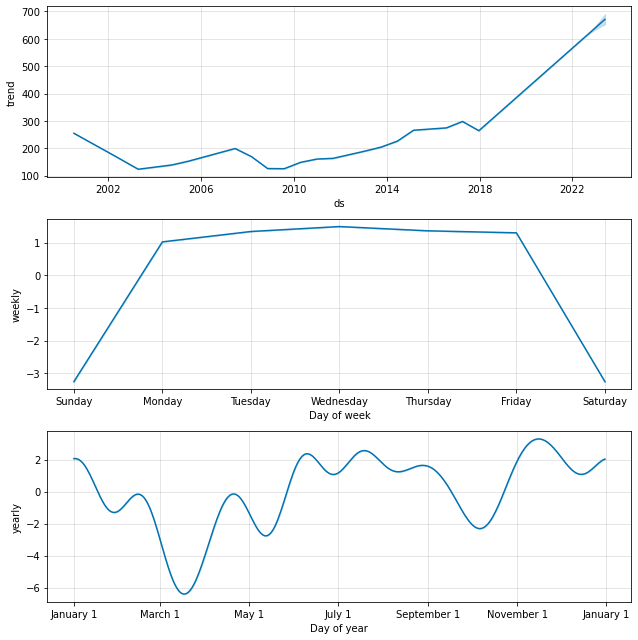

In [11]:
fig2 = m.plot_components(forecast)

An interactive figure of the forecast and components can be created with plotly. You will need to install plotly 4.0 or above separately, as it will not by default be installed with prophet. You will also need to install the notebook and ipywidgets packages.

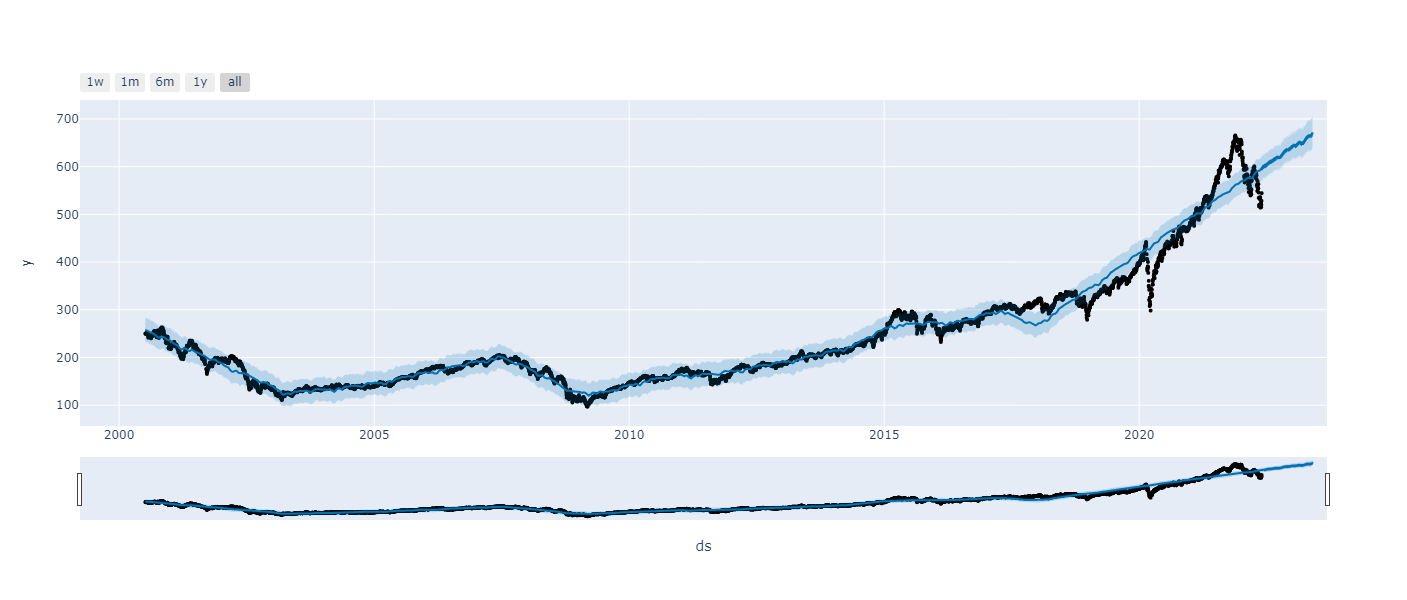

In [12]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

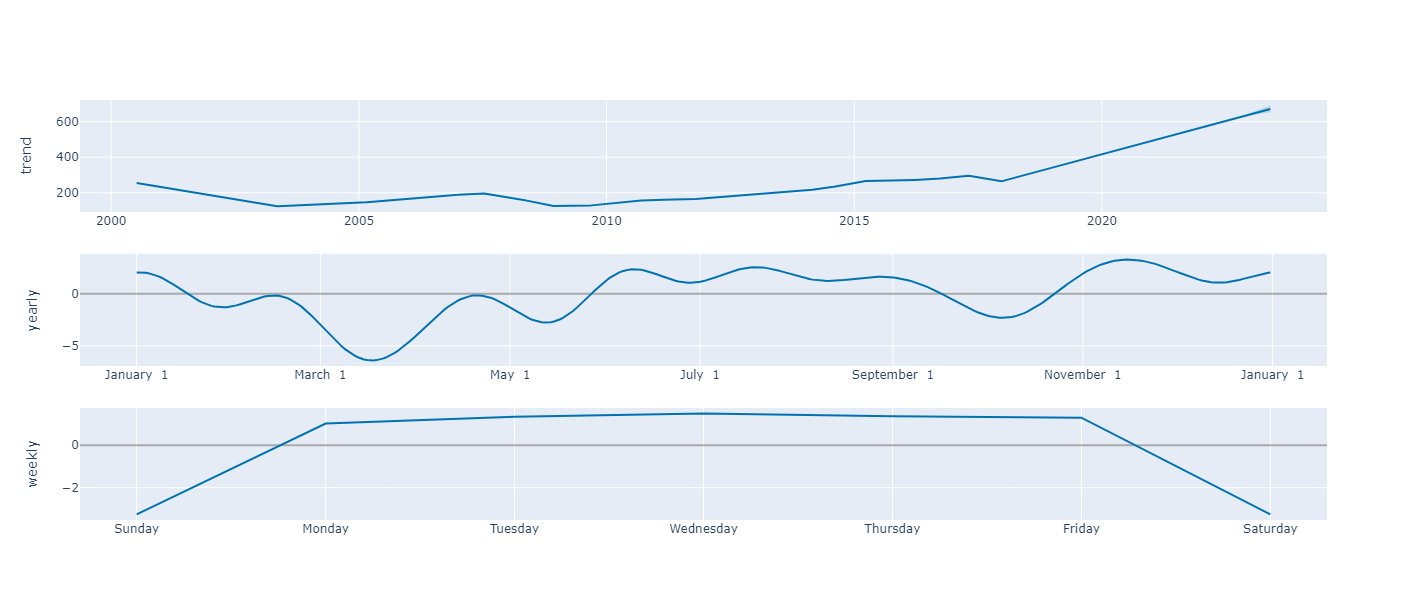

In [13]:
# Python
plot_components_plotly(m, forecast)

## Parallelized Cross validation

In [14]:
from prophet.diagnostics import cross_validation
from dask.distributed import Client

client = Client()  # connect to the cluster

df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days',

                         parallel="dask")

INFO:prophet:Making 39 forecasts with cutoffs between 2002-09-04 00:00:00 and 2021-05-27 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:51723' processes=4 threads=8, memory=15.39 GiB>


In [15]:
df_cv.head()

ds        yhat  yhat_lower  yhat_upper       y     cutoff
0 2002-09-05  141.728126  135.623588  147.705854  138.69 2002-09-04
1 2002-09-06  140.749918  135.011909  146.812228  141.84 2002-09-04
2 2002-09-09  139.888890  133.740261  145.534491  142.35 2002-09-04
3 2002-09-10  139.492007  133.898615  145.475258  144.90 2002-09-04
4 2002-09-11  138.585090  132.829882  144.448838  146.47 2002-09-04

In [16]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

horizon         mse       rmse        mae      mape     mdape     smape  \
0 37 days  508.287676  22.545236  15.303678  0.067078  0.045116  0.069112   
1 38 days  513.320305  22.656573  15.415263  0.067651  0.045180  0.069638   
2 39 days  517.537118  22.749442  15.458038  0.067743  0.045446  0.069750   
3 40 days  533.351722  23.094409  15.631418  0.068170  0.045608  0.070226   
4 41 days  551.500186  23.484041  15.865637  0.069062  0.045999  0.071109   

   coverage  
0  0.484458  
1  0.479899  
2  0.482989  
3  0.484345  
4  0.479302

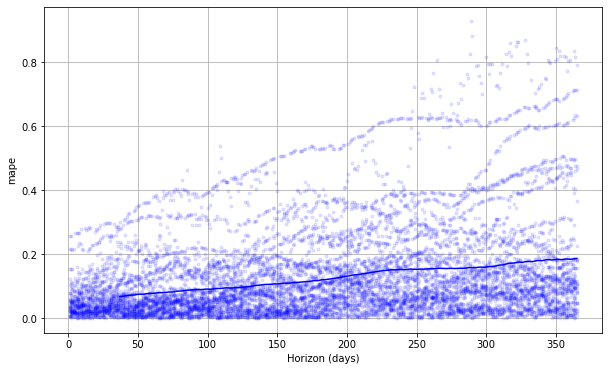

In [17]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

## Hyperparameter tuning

In [ ]:
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(gsef)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='30 days', parallel="dask")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 41 forecasts with cutoffs between 2002-08-10 00:00:00 and 2022-04-27 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:51723' processes=4 threads=8, memory=15.39 GiB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 41 forecasts with cutoffs between 2002-08-10 00:00:00 and 2022-04-27 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:51723' processes=4 threads=8, memory=15.39 GiB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 41 forecasts with cutoffs between 2002-08-10 00:00:00 and 2022-04-27 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:51723' processes=4 threads=8, memory=15.39 GiB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with 

In [ ]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

### Next:

1) Check if the best_params improve the main model's accuracy and if the RMSE is better than that of the pmdarima model (on the latest data). If so, set the best params as part of the main Prophet model
2) Can more hyperparameter tuning can be done to significantly improve accuracy?
3) Check if Prophet's output has been suppressed 
4) If necessary, re-order the analysis in the notebook and automate the analysis wherever possible (mainly in setting the value of each parameter in best_params to a variable and then assigning the corresponding variable in the model's initiation)
5) Remove any unnecessary or low value steps from the analysis 
6) Document the notebook 
7) Create a .py script of the notebook 
8) Publish the project publicly on Github

In [ ]:
# Calculate and print the time elapsed to run ETL process and the date and time of the latest run
time_elapsed = timeit.default_timer() - start_time

time_elapsed_seconds = int(time_elapsed % 60)

now = dt.datetime.now()

print("\n Success! Your GSEF forecast using Prophet has been updated in {} seconds on {}".format(time_elapsed_seconds, now.strftime("%Y-%m-%d %H:%M:%S")))